In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

from models import gen_model
import pandas as pd
import tensorflow as tf
pd.options.mode.chained_assignment = None  # default='warn'
from mm_utils import *
from models import gen_model, pearson
from mm_gen import MissGen
from tensorflow.keras.models import load_model
import pickle
import argparse
from scipy.stats import pearsonr
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
import time
import gc

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

2024-03-04 22:14:43.683227: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import random

random_seed = 42 
random.seed(random_seed )  # set random seed for python
np.random.seed(random_seed )  # set random seed for numpy
tf.random.set_seed(random_seed )  # set random seed for tensorflow-cpu

In [3]:
w = 15
flank = 100

In [4]:
train_locs = pd.read_csv('../../GSE110582_RAW/GSM3003539_Homo_all_w15_th-1_train.K.bedGraph', header=None, names=["chr", "start", "end", "mm", "mp"], 
                         dtype={'chr': 'category', 'start': np.int32, 'end': np.int32, 'mm': np.float32, 'mp': 'category'}, sep='\t')
# train_locs = pd.read_csv('../GSM3003539_Homo_all_w15_th-1_train.K.bedGraph', header=None, names=["chr", "start", "end", "mm", "mp"], sep='\t')
len_seq = train_locs['end'] - train_locs['start']
rv_ind = len_seq[len_seq != w].index
train_locs = train_locs.drop(index=rv_ind).reset_index(drop=True)
chr_list = list(train_locs['chr'].unique())
genome = read_genome('../../detail/ucsc.hg19.fasta', chr_list)

val_locs = pd.read_csv('../../GSE110582_RAW/GSM3003539_Homo_all_w15_th-1_test.K.bedGraph', header=None, names=["chr", "start", "end", "mm", "mp"],
                       dtype={'chr': 'category', 'start': np.int32, 'end': np.int32, 'mm': np.float32, 'mp': 'category'}, sep='\t')
# val_locs = pd.read_csv('../GSM3003539_Homo_all_w15_th-1_test.K.bedGraph', header=None, names=["chr", "start", "end", "mm", "mp"], sep='\t')
len_seq = val_locs['end'] - val_locs['start']
rv_ind = len_seq[len_seq != w].index
val_locs = val_locs.drop(index=rv_ind).reset_index(drop=True)
val_chr_list = list(val_locs['chr'].unique())
val_genome = read_genome('../../detail/ucsc.hg19.fasta', val_chr_list)

# print('len of train_data: {}, len of test_data: {}'.format(len(train_locs), len(val_locs)))

In [6]:
train_locs = train_locs.sample(frac=1).reset_index(drop=True)

In [7]:
train_locs.head()

,chr,start,end,mm,mp
0,chr11,30591117,30591132,0.400000,-
1,chr13,75986735,75986750,0.000000,+
2,chr4,116242911,116242926,0.100000,-
3,chr22,29259260,29259275,55.799999,+
4,chr9,140294119,140294134,4.900000,-


In [13]:
train_gen = MissGen(bs=256,
                    genome=genome,
                    locs=train_locs,
                    flank=100,
                    shuffle=False,
                    stat='train',
                    train=True,
                    val_N=0.25)

val_gen = MissGen(bs=512,
                    genome=val_genome,
                    locs=val_locs,
                    flank=100,
                    shuffle=False,
                    stat='test',
                    train=True,
                    val_N=0.25)

In [9]:
train_gen.__getitem__(0)[1]

array([ 0.4,  0. ,  0.1, 55.8,  4.9, 18.6,  0.4,  0. ,  0.1,  0.1,  0.2,
        0. ,  0. ,  0. , 54. ,  0.7,  0.1,  1.4,  0.3,  0. ,  0. ,  0.4,
        1.3,  0.8,  0. ,  0.5,  0. ,  1.5,  3.4, 25.9,  0.1,  0.1,  3.4,
        0.7,  0.1, 20.4,  0. ,  0.1,  0.6,  2.5,  1.9,  0.3,  0. ,  0.6,
        0.6,  0. ,  0.1,  0.1,  4.5,  0. ,  0. ,  0.4,  2. ,  0.2,  0.2,
        7.9,  0. ,  0.5,  0. ,  1.2,  1.3, 11.2,  1.8,  0. ,  0.2,  0. ,
        0.1,  0. ,  0.6,  0.4,  0. , 34.4,  9.9,  0.1,  0. ,  0.1,  0.2,
        0.6,  2. ,  0. ,  6.4,  0. ,  0.2,  0.7,  0. ,  0.7,  0.1,  0.2,
        1.2,  0.7,  0.1,  0.5,  0. ,  2.8,  0.6,  0. ,  0.7,  0.6,  0.5,
        0. ,  3.4,  0. ,  2.4,  1.2,  3.9,  1. ,  0.1,  1.2,  0.1,  0.1,
        0. , 21.2,  1. ,  0.3,  0.2,  1.5,  0.1, 13.4,  2.1,  0. ,  0. ,
        6. ,  0. ,  0.1,  0. ,  0.4,  0.7,  4.6,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0. ,  0. ,  0. ,  0. ,  1.2,  0.5,  0.1,  0.1,  0.5,
        0.1,  0. ,  0. ,  0.1,  0. ,  0.3,  0. ,  0

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import *
from models import TransformerBlock

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'   #设置为1屏蔽一般信息，2屏蔽一般和警告，3屏蔽所有输出 

inputs = Input(shape=(215, 4))
x = Conv1D(64, 15, padding='same')(inputs)
x = BatchNormalization(axis=2)(x)

trans_block = TransformerBlock(64, 4, 256)
x, attention = trans_block(x)

x = Bidirectional(GRU(64))(x)
x = Dense(32, 'relu')(x)
outputs = Dense(1, 'linear')(x)

model4 = Model(inputs=inputs, outputs=outputs)

model4.summary()
exp_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.99
)

cp2 = ModelCheckpoint('Transformer_kernelsize_15/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(exp_decay), metrics=[pearson, tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

model4.fit(x=train_gen, validation_data=None, epochs=1, callbacks=[cp2], use_multiprocessing=True, shuffle=False)

2024-03-04 22:21:41.751371: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2024-03-04 22:21:41.774768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2024-03-04 22:21:41.774869: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2024-03-04 22:21:41.781681: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2024-03-04 22:21:41.787577: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2024-03-04 22:21:41.788407: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 215, 4)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 215, 64)           3904      
_________________________________________________________________
batch_normalization (BatchNo (None, 215, 64)           256       
_________________________________________________________________
transformer_block (Transform ((None, 215, 64), (None,  49984     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49920     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [8]:
# save weights

model4.save_weights('model_weghts.h5')

In [9]:
len(val_locs['mm'])

29923093

In [14]:
# evaluate

pred = model4.predict(x=val_gen, use_multiprocessing=True, workers=20, verbose=2)
val_locs['score'] = pred.squeeze()
# 屏蔽结果保存部分的代码
val_locs[['score', 'mm']].to_csv('./test_K_PDS.csv', index=False)
r = pearsonr(pred.squeeze(), np.array(val_locs['mm']))

# result
print('pearson correalation = {:.3f}, p value = {:.3f}'.format(r[0], r[1]))

58444/58444 - 2494s
pearson correalation = 0.941, p value = 0.000


In [12]:
from sklearn.metrics import jaccard_score

labels = [1 if item > 35 else 0 for item in val_locs['mm'].astype('float32')]
threshold_start = 30
to_add = 0.1

for i in range(50):
    threshold = threshold_start + to_add * i
    preds = [1 if item > threshold else 0 for item in pred.squeeze()]

    print(jaccard_score(labels, preds))

0.6953145600416221
0.696549318418308
0.6977388451240463
0.6989569607429699
0.7000469863979173
0.7012515605418057
0.7024472313108504
0.7035851565508672
0.7045488233078596
0.7055993251504575
0.7066200215285253
0.7075285311081114
0.7084449007680764
0.7093713061876337
0.7101822953127072
0.7110300661784082
0.7118986066267847
0.7125695091667658
0.7132936545283656
0.7139695691416443
0.714655153908222
0.7151921900508766
0.7156116664189693
0.716090184946412
0.716509553912229
0.7168426353916911
0.7170924969736534
0.7173533119043998
0.717550542423839
0.7177514999980558
0.7178743936234928
0.7178143429669935
0.7178014240930195
0.7176822797248608
0.7176903369900808
0.7175475386341962
0.7173556753244523
0.7170236738174014
0.7165940423747148
0.7162889725744853
0.7158488532471101
0.7154449148575968
0.7150189268020675
0.7145413942389087
0.713823781331983
0.7130660612302472
0.7122907748837863
0.7114195605837912
0.7106221232287515
0.7096887094885183


In [13]:
from sklearn.metrics import recall_score, precision_score

threshold = 33.1
preds = [1 if item > threshold else 0 for item in pred.squeeze()]

print('precision:{}, recall:{}'.format(precision_score(labels, preds), recall_score(labels, preds)))

precision:0.846627775600083, recall:0.825108876241384


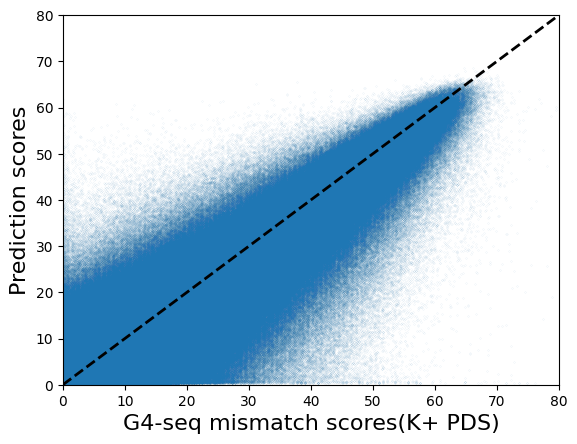

In [ ]:
# 结果图

# import seaborn
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.weight'] = 'bold'

k_file = '../final/Transformer_15.csv'
data = pd.read_csv(k_file, delimiter=',')

def parity_plot(model_name, truth, pred, rmse):
    '''
    Given a dataframe of samples with their true and predicted values,
    make a scatterplot.
    '''
    plt.scatter(truth, pred, s=0.001)
    plt.gca().set_xmargin(1)  # 0.05是一个相对边距的比例值
    plt.gca().set_ymargin(1)  # 0.05是一个相对边距的比例值

    # y=x line
    plt.ylim([0, 80])  # Set y-axis limits
    plt.xlim([0, 80])  # Set x-axis limits
    plt.xticks(range(0, 81, 20))  # Set x-axis ticks
    plt.yticks(range(0, 81, 20))  # Set y-axis ticks
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    # plt.ylim(xpoints)
    plt.ylabel("Prediction scores", fontsize=16, fontweight='bold')
    plt.xlabel("G4-seq mismatch scores(K+)", fontsize=16, fontweight='bold')
    # plt.text(0, 1, 'R=0.94', fontsize=12, ha='center', va='center')
    # plt.text(1, 1, f'R=0.94', fontsize=16, 
    #      ha='right', va='bottom', transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))
    # plt.title(f"{model_name} (rmse:{rmse:.3f})",fontsize=16)
    plt.savefig("K.png", dpi=500, bbox_inches = 'tight')#解决图片不清晰，不完整的问题
    plt.show()

parity_plot('TranG4 ', data['mm'].values, data['score'].values, 1.7729517)